In [1]:
%matplotlib notebook

import xemc3
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# load dataset for geometry matrix mapping from & mapping itself

In [2]:
bolotype = "QRB"
ds_map = xr.open_dataset(f"./{bolotype}-dataset.nc")

In [3]:
ds_map

<xarray.Dataset>
Dimensions:  (foil: 88, p: 10, z: 85, r: 47, hit: 2, xyz: 3, sample: 20, xemc3_vars: 3, dp: 2, dz: 2, dr: 2)
Coordinates:
    x_vert   (p, z, r, dp, dz, dr) float64 ...
    y_vert   (p, z, r, dp, dz, dr) float64 ...
    z_vert   (p, z, r, dp, dz, dr) float64 ...
    phi      (p) float64 ...
Dimensions without coordinates: foil, p, z, r, hit, xyz, sample, xemc3_vars, dp, dz, dr
Data variables:
    S        (foil, p, z, r) float64 ...
    V        (p, z, r) float64 ...
    Etendue  (foil) float64 ...
    los      (foil, hit, xyz) float64 ...
    Vlos     (foil) float64 ...
    dlos     (foil) float64 ...
    id       (foil) object ...
    Map      (p, z, r, sample, xemc3_vars) float64 ...
Attributes:
    environment:  QRB
    description:  x,y,z_vert = voxel vertices \nphi [deg] = slice toroidal an...

# load dataset for geometry matrix mapping to & values to apply on

In [4]:
experiment  = "N03.00_P05.00_D05_C04.50-TEST"
ds = xr.open_dataset(f"../atomdatpy/NetCDFs/{experiment}_Ez.nc")

In [5]:
ds

<xarray.Dataset>
Dimensions:     (Ionization: 7, r: 139, theta: 512, phi: 36)
Coordinates:
  * Ionization  (Ionization) int64 0 1 2 3 4 5 6
Dimensions without coordinates: r, theta, phi
Data variables:
    Ez          (Ionization, r, theta, phi) float64 ...

# mapping

we want to map the geometry matrix from gabrieles cylindrical grid (C) on to my xemc3 toriodal (T) grid (both may change) to apply it to the Emissivity values to calculate the sightline foil power absorption values from.

The mapping (M) takes the cell indices (l,m,n) of the cylindrical grid cell as well as an extra index (q in [0,Q]) defining the position inside the cell, and maps that to the indices (i,j,k) of the toroidal grid cell
As the geometry marix values (g) are extensive values, we can sum them together for the fusion of two cells.
So as we subsample the cylindrical grid cells into Q subcells, each of these has geometry matrix value $g_{\text{subcell}} = g_{\text{cell}}/Q$.
Then we can add the subcell-g's for all C-subcells that lie in the T-cell together to get $g^T_{i,j,k}$:

$$
M: [0,\hat{l}] \times [0,\hat{m}] \times [0,\hat{n}] \times [0,Q] 
\to [0,\hat{i}] \times [0,\hat{j}] \times [0,\hat{k}], \quad (l,m,n,q) \mapsto (M_i(l,m,n,q),~M_k(l,m,n,q),~M_j(l,m,n,q))\\
\delta_{(i,j,k),~ M(l,m,n,q)} := \delta_{i,~ M_i(l,m,n,q)} \cdot \delta_{j,~ M_j(l,m,n,q)} \cdot \delta_{k,~ M_k(l,m,n,q)} \quad \text{Which describes if }l,m,n,q\text{ maps to }i,j,k\text{.}$$


$$ \Large
g^T_{i,j,k} = 
 \sum_{l,m,n,q} \frac{g^C_{l,m,n}}{Q} \cdot \delta_{(i,j,k),~ M(l,m,n,q)}$$
 
We could try to improve the accuracy of the mapped geometry matrix by taking into account the Volume of the C-subcells that lie in the new cell vs the volume of the T-cell, but this breaks dramatically when the volume of the T-cells gets much smaller than the C-subcell volumes, because then instead of one C-cell with $g_1$ mapping to n-1 T-cells with $g=0$ and one with $g=g_1$, it would map the one to $g=g_1/Q$ which drastically reduces the geometry matrix sum.

In [6]:
# could do iterative for each g^T, but thats O(n^3) times slower than looping over g^C and inserting 
# even if done with python

In [7]:
# all subcell T-indices
indices = ds_map.Map.values.reshape(-1,3)
# the indices of the (T-indices which are nan) in the current array, named "indices"
nan_indices_indices = ~np.isnan(indices[:,0])  
indices = indices[nan_indices_indices].astype(int)
r_ind, tht_ind, phi_ind = indices.T

In [11]:
# corresponding C-cell geometry matrix values
geom_values = ds_map["S"].expand_dims(sample=ds_map.sample)\
                         .transpose("p", "z", "r", "sample", "foil")\
                         .values.reshape(-1, ds_map.foil.size)\
                         [nan_indices_indices]
# needs to be divided by Q for further use
geom_values /= ds_map.sample.size

In [12]:
# now create geom matrix in T-data, and loop over the arrays to sum everything together.
ds = ds.assign_coords({"foil":ds_map.foil})
ds["foil_geom_matrix"] = (["foil", "r", "theta", "phi"], 
                          np.zeros((ds.foil.size, ds.r.size, ds.theta.size, ds.phi.size)))

for i, (ri, thti, phii, foil_geoms) in enumerate(zip(r_ind, tht_ind, phi_ind, geom_values)):
    if not i%10000:
        print(i)
    ds["foil_geom_matrix"][:,ri,thti,phii] += foil_geoms
    #ds["foil_geom_matrix"].isel(r=ri, theta=thti, phi=phii) += geom_values

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000


In [16]:
# try to plot something
# ds_map.foil_id
foil_id = 26
print(ds_map.id[foil_id])

ds_all = xr.open_dataset(f"../atomdatpy/NetCDFs/{experiment}.nc")
sf = lambda x: np.log(x + 1e-36)
# ds_all["foilsum"] = sf(ds["foil_geom_matrix"][foil_id] * ds.Ez.sum(dim="Ionization"))
ds_all["foilsum"] = sf(ds["foil_geom_matrix"].sum(dim="foil") * ds.Ez.sum(dim="Ionization"))

<xarray.DataArray 'id' ()>
array('AEJDIV Foil 7', dtype=object)


<IPython.core.display.Javascript object>


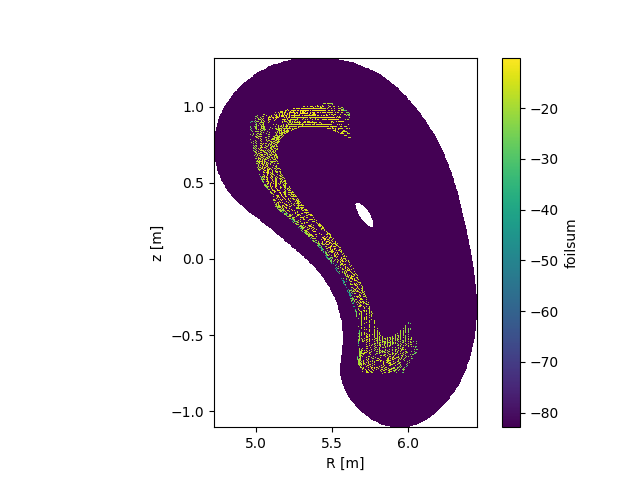

interactive(children=(FloatSlider(value=0.3528859116189509, description='ip', max=0.3528859116189509, min=0.13…

<function __main__.plot_Te(ip)>

In [17]:
tmpphi = (ds_map.phi * np.pi/180) % (2*np.pi/5)
tmpphi = np.minimum(tmpphi, 2*np.pi/5 - tmpphi)
eps = 0.03

import ipywidgets as widgets
fig = plt.figure()
def plot_Te(ip):
    fig.clear()
    ds_all.emc3.plot_rz("foilsum", phi=ip)
ip = widgets.FloatSlider(min=tmpphi.min()-eps, max=tmpphi.max()+eps, value=np.pi/5, step=0.005)
widgets.interact(plot_Te, ip = ip)
# ds_map["foil_id"]

# Comparison with Gabriele

In [18]:
def crossec_pcolorgrid_gabriele(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["z"])+1, len(ds["r"])+1))
    outZ = outR.copy()
    
    outZ[:-1,:-1] = ds["z_vert"][phi, :, :,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_vert"][phi, :,-1,0,0,1]  # A
    outZ[ -1,:-1] = ds["z_vert"][phi,-1, :,0,1,0]  # B
    outZ[ -1, -1] = ds["z_vert"][phi,-1,-1,0,1,1]  # 1
    
    outR[:-1,:-1] = np.sqrt( ds["x_vert"][phi, :, :,0,0,0]**2 + ds["y_vert"][phi, :, :,0,0,0]**2 ) # AB
    outR[:-1, -1] = np.sqrt( ds["x_vert"][phi, :,-1,0,0,1]**2 + ds["y_vert"][phi, :,-1,0,0,1]**2 ) # A
    outR[ -1,:-1] = np.sqrt( ds["x_vert"][phi,-1, :,0,1,0]**2 + ds["y_vert"][phi,-1, :,0,1,0]**2 ) # B
    outR[ -1, -1] = np.sqrt( ds["x_vert"][phi,-1,-1,0,1,1]**2 + ds["y_vert"][phi,-1,-1,0,1,1]**2 ) # 1
    
    return outR.T, outZ.T

def crossec_pcolorgrid_philip(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["r"])+1, len(ds["theta"])+1))
    outZ = outR.copy()
    
    outR[:-1,:-1] = ds["R_bounds"][ :, :,phi,0,0,0]  # AB
    outR[:-1, -1] = ds["R_bounds"][ :,-1,phi,0,1,0]  # A
    outR[ -1,:-1] = ds["R_bounds"][-1, :,phi,1,0,0]  # B
    outR[ -1, -1] = ds["R_bounds"][-1,-1,phi,1,1,0]  # 1
    
    outZ[:-1,:-1] = ds["z_bounds"][ :, :,phi,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_bounds"][ :,-1,phi,0,1,0]  # A
    outZ[ -1,:-1] = ds["z_bounds"][-1, :,phi,1,0,0]  # B
    outZ[ -1, -1] = ds["z_bounds"][-1,-1,phi,1,1,0]  # 1
    
    return outR, outZ

In [19]:
def approx_volume(ds_all): # APPROXIMATION
    # ds_all.R_bounds.diff(dim="delta_r").diff(dim="delta_theta").diff(dim="delta_phi").squeeze(dim=("delta_r", "delta_theta", "delta_phi"))
    drr = ds_all.R_bounds.diff(dim="delta_r").squeeze(dim="delta_r").mean(dim=("delta_theta", "delta_phi"))
    dzr = ds_all.z_bounds.diff(dim="delta_r").squeeze(dim="delta_r").mean(dim=("delta_theta", "delta_phi"))

    drtht = ds_all.R_bounds.diff(dim="delta_theta").squeeze(dim="delta_theta").mean(dim=("delta_r", "delta_phi"))
    dztht = ds_all.z_bounds.diff(dim="delta_theta").squeeze(dim="delta_theta").mean(dim=("delta_r", "delta_phi"))

    # length = r * dphi
    dlphi = ds_all.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")) * \
            ds_all.phi_bounds.diff(dim="delta_phi").squeeze(dim="delta_phi")  # .data[None, None, :]  dont need to do cause of xarray dims

    # vol = det ((drr, drtht, 0), (dzr, dztht, 0), (0, 0, dlphi))
    #     = det ((drr, drtht), (dzr, dztht)) * dlphi
    #     = (drr * dztht - dzr * drtht) * dlphi
    vols = (drr * dztht - dzr * drtht) * dlphi
    return vols

In [20]:
# ds      # ds_matrix
# ds_map  # ds_gabriele
# ds_all  # ds_emc3

In [21]:
import ipywidgets as widgets
def combination_plot(ds_gabriele, ds_emc3, ds_matrix, phi, foil_index=0, scale_by_volume=False, sf=lambda x: x):
    # embed matrix into coords
    ds_emc3["foil_geom_matrix"] = ds_matrix["foil_geom_matrix"]
    ds_emc3["volumes"] = approx_volume(ds_emc3) # (["r", "theta", "phi"], approx_volume(ds_emc3))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,7))
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    fig.tight_layout()
    
    def _combination_plot(phi):
        # plot 1
        axs[0].clear()
        first_module_phi = np.minimum( phi%(2*np.pi/5), 2*np.pi/5 - phi%(2*np.pi/5) )
        phi_index = np.searchsorted(ds_emc3.phi_bounds[:,1], first_module_phi)
                   # np.clip(np.searchsorted(ds_emc3.phi_bounds[:,1], phi),
                   #          0, len(ds_emc3.phi_bounds[:,1])-1)
        try:
            R, Z = crossec_pcolorgrid_philip(ds_emc3, phi_index)
            C = ds_emc3["foil_geom_matrix"].isel(phi=phi_index, foil=foil_index).copy()
            if scale_by_volume:
                C /= ds_emc3["volumes"].isel(phi=phi_index)
            cb = axs[0].pcolormesh(R, Z, sf(C))
            # fig.colorbar(cb, ax=axs[0])
        except:
            ...

        # plot 2
        axs[1].clear()
        phi_index = np.argmin(( (ds_gabriele.phi * (np.pi/180) - phi)**2 ).data)
        R,Z = crossec_pcolorgrid_gabriele(ds_gabriele, phi_index)
        C = ds_gabriele["S"].isel(p=phi_index, foil=foil_index).T.copy()
        if scale_by_volume:
            C /= ds_gabriele["V"].isel(p=phi_index).T
        axs[1].pcolormesh(R, Z, sf(C))
    

    delta_phi = np.mean(np.diff(ds_gabriele.phi.data)) * (np.pi/180)
    all_phi = ds_gabriele.phi.data * (np.pi/180)
    interactive_phi = widgets.FloatSlider(min=min(all_phi) - delta_phi/2, 
                                          max=max(all_phi) + delta_phi/2, 
                                          value=np.mean(all_phi), step=delta_phi/2)
    widgets.interact(_combination_plot, phi=interactive_phi)

<IPython.core.display.Javascript object>


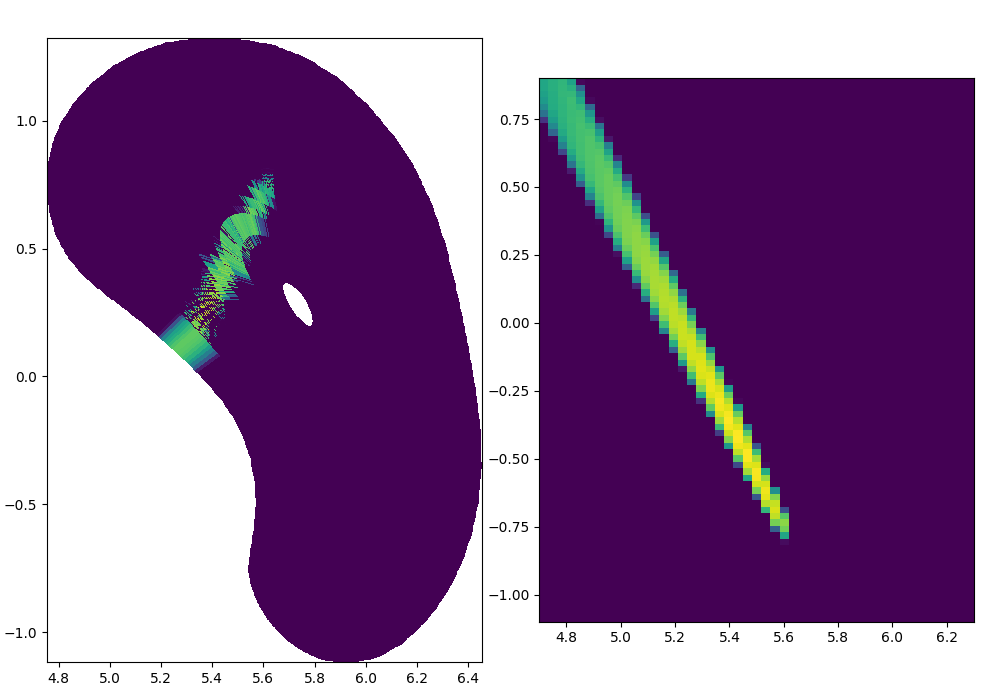

interactive(children=(FloatSlider(value=3.5255650890285453, description='phi', max=3.612831551628262, min=3.43…

In [22]:
combination_plot(ds_map, ds_all, ds, phi=1.85, foil_index=27, sf = lambda x: np.log(x+1e-10), scale_by_volume=True)  # np.log(x + 1e-12)

# absorbed power

In [23]:
foil_Ez = ds["foil_geom_matrix"] * ds.Ez.sum(dim="Ionization") # ds.Ez[4]  # 

In [10]:
ds["foil_geom_matrix"][10,0,50,13]

<xarray.DataArray 'foil_geom_matrix' ()>
array(5.15592377e-12)
Coordinates:
    foil     int64 10

In [24]:
foil_Ez_sum = foil_Ez.sum(dim=("r", "theta", "phi"))

<IPython.core.display.Javascript object>


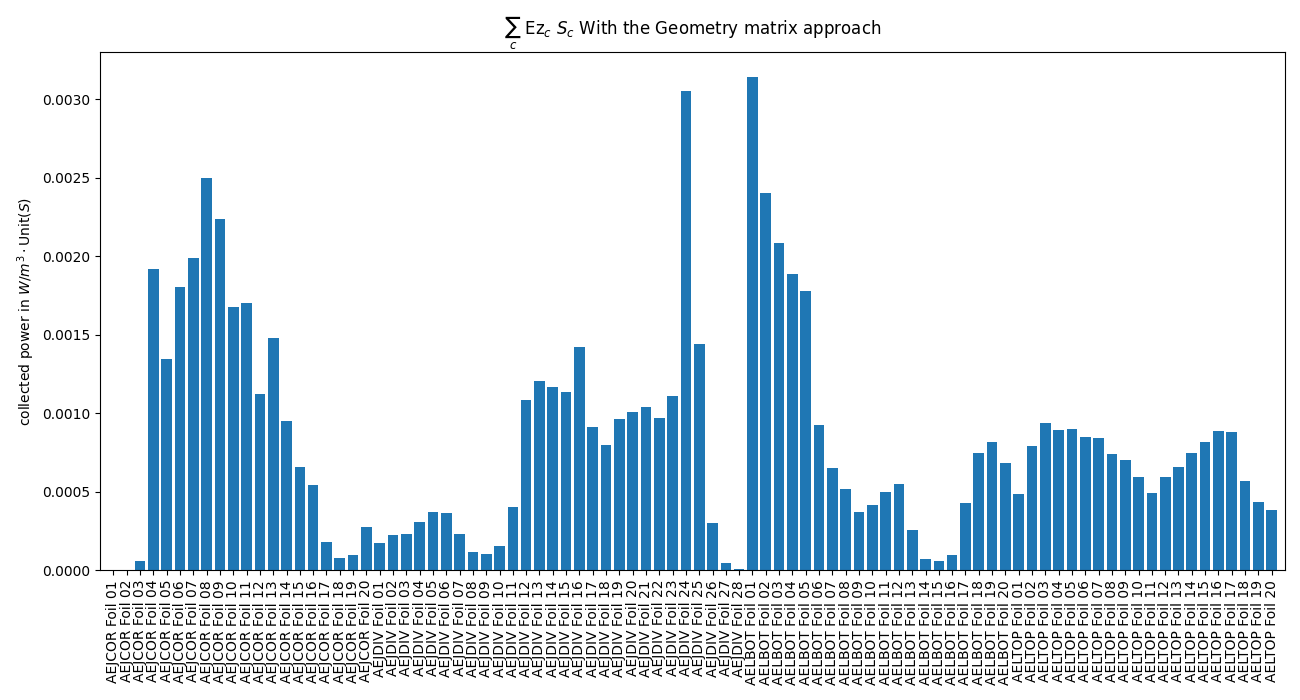

Ellipsis

In [25]:
fig, ax = plt.subplots(figsize=(13,7))
tmp_x = range(len(foil_Ez_sum))

labels = []
for l_str in ds_map.id:
    l_str = l_str.data[()]
    front = " ".join(l_str.split(" ")[:-1])
    back = f"{int(l_str.split(' ')[-1]):02d}"
    labels.append(front+" "+back)

ax.bar(tmp_x, foil_Ez_sum)
ax.set_xticks(tmp_x)
ax.set_xticklabels(labels, rotation=90)
ax.set_xlim(-1, len(foil_Ez_sum))
ax.set_title("$\sum_c ~\mathrm{Ez}_c ~S_c$ With the Geometry matrix approach")
ax.set_ylabel("collected power in $W/m^3 \cdot \mathrm{Unit}(S)$")
fig.tight_layout()
...

In [100]:
fig.savefig(f"../images/geom_matrix_P_{bolotype}.pdf")

In [101]:
fig.savefig(f"../images/geom_matrix_P_{bolotype}.png")

In [102]:
np.savez(f"emc3_grid_sestivity_mapping_{bolotype}", data=foil_Ez_sum, labels=labels)

In [105]:
foil_Ez_sum.shape

(88,)

In [107]:
len(labels)

88

In [103]:
foil_Ez_all = ds["foil_geom_matrix"] * ds.Ez
foil_Ez_sum_all = foil_Ez_all.sum(dim=("r", "theta", "phi"))

In [104]:
np.savez("emc3_grid_sestivity_mapping_all", data=foil_Ez_sum_all, labels=labels)